In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score


## Part A - Classification Tree (50 points)

### A-1 Data Processing and EDA

#### 1. Read Data

In [50]:

train_data = pd.read_csv('data_train.csv')

#### 2. Print data, how does the data look like? Short description on the data

In [51]:
train_data = train_data.drop(train_data.columns[0], axis=1)
print(train_data.head())

    Loan_ID Gender Married Dependents Education Self_Employed  \
0  LP001518   Male     Yes          1  Graduate            No   
1  LP002734   Male     Yes          0  Graduate            No   
2  LP002697   Male      No          0  Graduate            No   
3  LP002455   Male     Yes          2  Graduate            No   
4  LP001732   Male     Yes          2  Graduate           NaN   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             1538             1425.0        30.0             360.0   
1             6133             3906.0       324.0             360.0   
2             4680             2087.0         NaN             360.0   
3             3859                0.0        96.0             360.0   
4             5000                0.0        72.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Urban           Y  
2             1.0     Semiurban           N 

This is a Loan Dataset where there 13 columns. 

There are 12 features and 1 label (Loan_Status)

There are 11 feature columns (excluding Loan_ID) which decide whether the loan is granted or not (Loan_Status label)


#### 3. Shape of the Data 

In [52]:
print(train_data.shape)

(491, 13)


#### 4. Does the data have any missing values? How many are missing? Process the data to remove these missing values. You can drop the corresponding rows or apply imputation.

In [53]:
print(f"Missing values in data = \n {train_data.isnull().sum()}")

Missing values in data = 
 Loan_ID               0
Gender               12
Married               3
Dependents           13
Education             0
Self_Employed        29
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           17
Loan_Amount_Term     12
Credit_History       43
Property_Area         0
Loan_Status           0
dtype: int64


In [54]:
# remove missing values 
train_data = train_data.dropna()

In [55]:
train_data.shape

(373, 13)

In [56]:
train_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001518,Male,Yes,1,Graduate,No,1538,1425.0,30.0,360.0,1.0,Urban,Y
1,LP002734,Male,Yes,0,Graduate,No,6133,3906.0,324.0,360.0,1.0,Urban,Y
3,LP002455,Male,Yes,2,Graduate,No,3859,0.0,96.0,360.0,1.0,Semiurban,Y
5,LP001841,Male,No,0,Not Graduate,Yes,2583,2167.0,104.0,360.0,1.0,Rural,Y
6,LP002348,Male,Yes,0,Graduate,No,5829,0.0,138.0,360.0,1.0,Rural,Y


#### 5. Extract the features and the label from the data

In [57]:
features = train_data.drop("Loan_Status", axis=1)
labels = train_data["Loan_Status"]
print(features.shape, labels.shape)

(373, 12) (373,)


In [58]:
# Separate categorical and numerical columns
categorical_cols = ['Gender', 'Married', 'Dependents','Education', 'Self_Employed','Credit_History','Property_Area']
numerical_cols = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']
label_col = 'Loan_Status'

# Apply label encoding to categorical columns
label_encoder = LabelEncoder()
train_data_encoded = train_data.copy()
for col in categorical_cols:
    train_data_encoded[col] = label_encoder.fit_transform(train_data[col])

# Extract labels and apply label encoding
y_encoded = label_encoder.fit_transform(train_data[label_col])

# Extract features
X_encoded = train_data_encoded[categorical_cols + numerical_cols]

y_encoded = label_encoder.fit_transform(train_data[label_col])
y_encoded = pd.Series(y_encoded)

X_encoded.head(20)


,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
0,1,1,1,0,0,1,2,1538,1425.0,30.0,360.0
1,1,1,0,0,0,1,2,6133,3906.0,324.0,360.0
3,1,1,2,0,0,1,1,3859,0.0,96.0,360.0
5,1,0,0,1,1,1,0,2583,2167.0,104.0,360.0
6,1,1,0,0,0,1,0,5829,0.0,138.0,360.0
7,0,0,0,0,1,1,1,15759,0.0,55.0,360.0
8,1,1,1,0,1,0,0,2178,0.0,66.0,300.0
9,0,0,0,0,0,1,1,4124,0.0,115.0,360.0
10,1,0,0,0,0,1,2,5316,0.0,136.0,360.0
12,1,1,3,0,0,1,0,15000,0.0,300.0,360.0


In [59]:
y_encoded.head(20)

0     1
1     1
2     1
3     1
4     1
5     1
6     0
7     1
8     1
9     1
10    0
11    1
12    0
13    1
14    1
15    1
16    0
17    1
18    1
19    1
dtype: int32

#### 6. Plot the histograms of all the variables in the data.


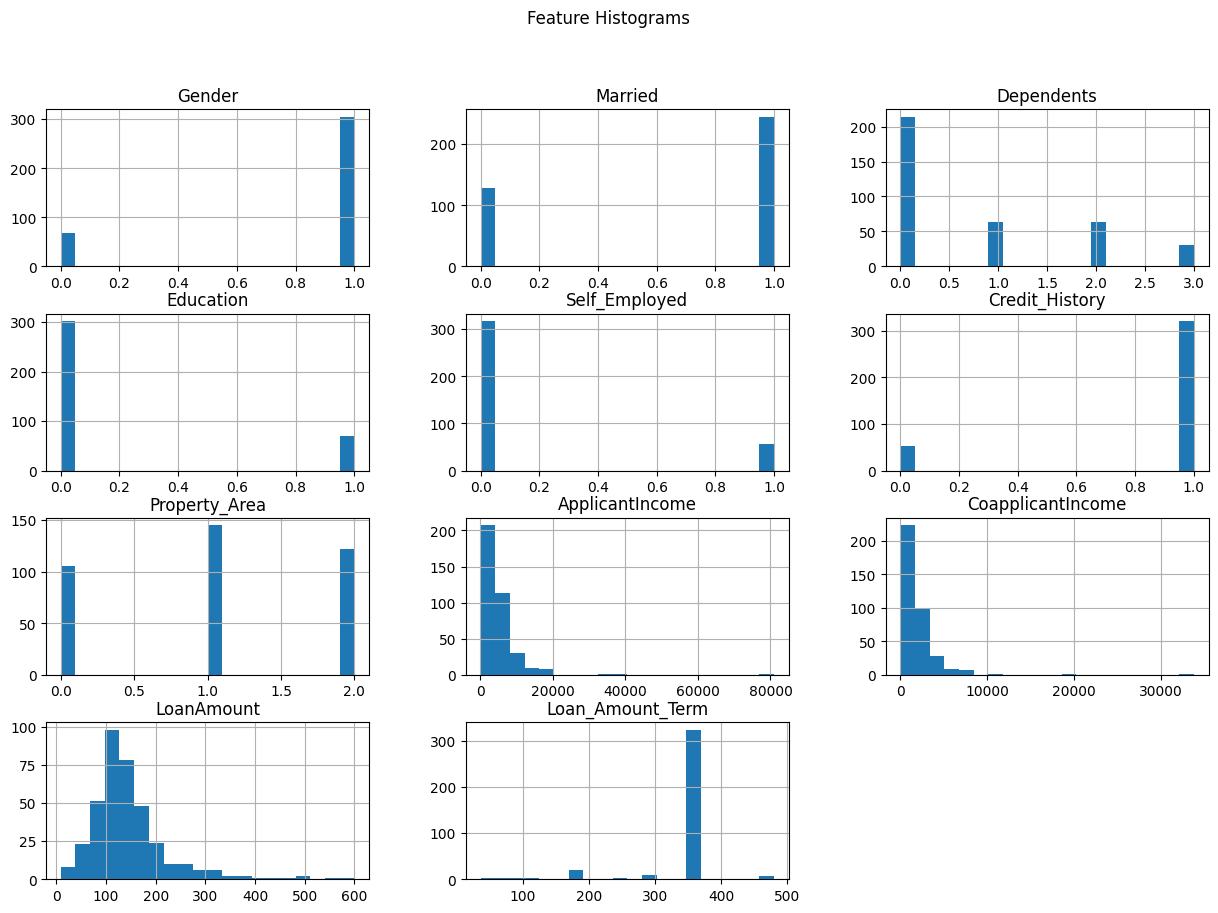

In [61]:
X_encoded.hist(bins=20, figsize=(15, 10))
plt.suptitle("Feature Histograms")
plt.show()

#### 7. What are the different feature types in this data

There are two feature types : Continous and Categorical 

Categorical data has distinct categories that does not have a natural ordering or rank between them. 

Continous data will usually be a numeric value in a specified range. 

In the given dataset, the Continous variables are as follows : 
1. ApplicantIncome
2. CoapplicantIncome
3. LoanAmount
4. Loan_Amount_Term

And, the Categorical features are as follows : 
1. Loan_ID
2. Gender
3. Married
4. Dependents
5. Education
6. Self_Employed
7. Credit_History
8. Property_Area
9. Loan_Status

Dependents and Credit_History are numeric variables but there are only fixed numeric values associated with it which act as classes and hence these columns are also considered to be Categorical in nature

### A-2 Implementation

#### 1.  Implement a classification tree from scratch for prediction.

In [62]:
# split data into training and validation sets 

split = int(len(train_data) * 0.8)


X_train = features[:split]
y_train = labels[:split]
X_val = features[split:]
y_val = labels[split:]

print(X_train, y_train)


      Loan_ID Gender Married Dependents     Education Self_Employed  \
0    LP001518   Male     Yes          1      Graduate            No   
1    LP002734   Male     Yes          0      Graduate            No   
3    LP002455   Male     Yes          2      Graduate            No   
5    LP001841   Male      No          0  Not Graduate           Yes   
6    LP002348   Male     Yes          0      Graduate            No   
..        ...    ...     ...        ...           ...           ...   
381  LP002068   Male      No          0      Graduate            No   
383  LP002493   Male      No          0      Graduate            No   
384  LP002453   Male      No          0      Graduate           Yes   
385  LP001256   Male      No          0      Graduate            No   
387  LP001119   Male      No          0      Graduate            No   

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0               1538             1425.0        30.0             360.0   
1

#### 2. Build the tree model using training data and Gini Index as the splitting criteria

In [63]:
import numpy as np
import pandas as pd

class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def gini_index(self, labels):
        unique_labels, counts = np.unique(labels, return_counts=True)
        probabilities = counts / len(labels)
        gini = 1 - np.sum(probabilities**2)
        return gini

    def calculate_gini_index(self, groups, labels):
        total_samples = sum(len(group) for group in groups)
        gini_index_value = 0.0

        for group in groups:
            size = len(group)
            if size == 0:
                continue
            proportion = size / total_samples
            gini_index_value += proportion * self.gini_index(labels[group])

        return gini_index_value

    def split_dataset(self, dataset, attribute, value):
        left_indices = np.where(dataset[attribute] <= value)[0]
        right_indices = np.where(dataset[attribute] > value)[0]
        return left_indices, right_indices

    def find_best_split(self, dataset, labels):
        best_gini_index = float('inf')
        best_split = None

        for attribute in dataset.columns[:-1]:  # Exclude the label column
            unique_values = dataset[attribute].unique()
            for value in unique_values:
                groups = self.split_dataset(dataset, attribute, value)
                gini_index_value = self.calculate_gini_index(groups, labels)

                if gini_index_value < best_gini_index:
                    best_gini_index = gini_index_value
                    best_split = (attribute, value, groups)

        return best_split

    def build_tree(self, dataset, labels, depth):
        dataset = dataset.reset_index(drop=True)
        labels = labels.reset_index(drop=True)
        if depth == 0 or len(np.unique(labels)) == 1:
            return {'label': max(labels, key=list(labels).count)}

        best_split = self.find_best_split(dataset, labels)
        if best_split is None:
            return {'label': max(labels, key=list(labels).count)}

        attribute, value, groups = best_split
        left_branch = self.build_tree(dataset.iloc[groups[0]], labels[groups[0]], depth - 1)
        right_branch = self.build_tree(dataset.iloc[groups[1]], labels[groups[1]], depth - 1)

        return {'attribute': attribute, 'value': value, 'left': left_branch, 'right': right_branch}

    def fit(self, X, y):
        self.tree = self.build_tree(X, y, self.max_depth)

    def predict_instance(self, tree, row):
        if 'label' in tree:
            return tree['label']
        if row[tree['attribute']] <= tree['value']:
            return self.predict_instance(tree['left'], row)
        else:
            return self.predict_instance(tree['right'], row)

    def predict(self, X):
        return X.apply(lambda row: self.predict_instance(self.tree, row), axis=1)


max_depth = 3  # You can adjust the maximum depth of the tree
dt = DecisionTree(max_depth=max_depth)
dt.fit(X_train, y_train)


#### 2.1 Validate the trained model with the validation data

In [64]:
# Validate the trained model
predictions_validation = dt.predict(X_val)
accuracy = np.sum(predictions_validation == y_val) / len(y_val)

print(f"Validation Accuracy: {accuracy}")

Validation Accuracy: 0.7866666666666666


#### 3. Using the trained model, conduct inference on the test data and save the predicted result in a separate file

In [65]:
test_data = pd.read_csv('data_test.csv')
test_data = test_data.drop(test_data.columns[0], axis=1)

predictions_test = dt.predict(test_data)

results = pd.DataFrame({'pred_tree': predictions_test})
results.to_csv('Neha_Manghnani_preds.csv', index=False)



## Part B - Boosting (30 points)

#### 1. XGBoost model with L2 regularization

In [66]:


def train_XGBoost(X, y):
    lambda_params = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
    results = {}

    for lam in lambda_params:
        model = xgb.XGBClassifier(objective='binary:logistic', reg_lambda=lam)

        # Using stratified K-fold cross-validation
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        auc_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')

        mean_auc = np.mean(auc_scores)
        results[lam] = mean_auc

    return results



#### 2. Train and test the model with the best parameters you found.

In [67]:
split = int(len(train_data) * 0.8)
X_train = X_encoded[:split]
y_train = y_encoded[:split]
X_val = X_encoded[split:]
y_val = y_encoded[split:]

results_dict = train_XGBoost(X_train, y_train)

best_lambda = max(results_dict, key=results_dict.get)
print(f"Optimal Lambda for L2 Regularization: {best_lambda}")
print(f"Mean AUC for Optimal Lambda: {results_dict[best_lambda]}")

best_model = xgb.XGBClassifier(objective='binary:logistic', reg_lambda=best_lambda)
best_model.fit(X_train, y_train)

best_model_predictions = best_model.predict(X_val)




Optimal Lambda for L2 Regularization: 10.0
Mean AUC for Optimal Lambda: 0.7202116402116403


#### 3. Plot the ROC curve for the XGBoost model on validation data and also print the area under the curve. 

Area under the ROC curve: 0.8472644376899696


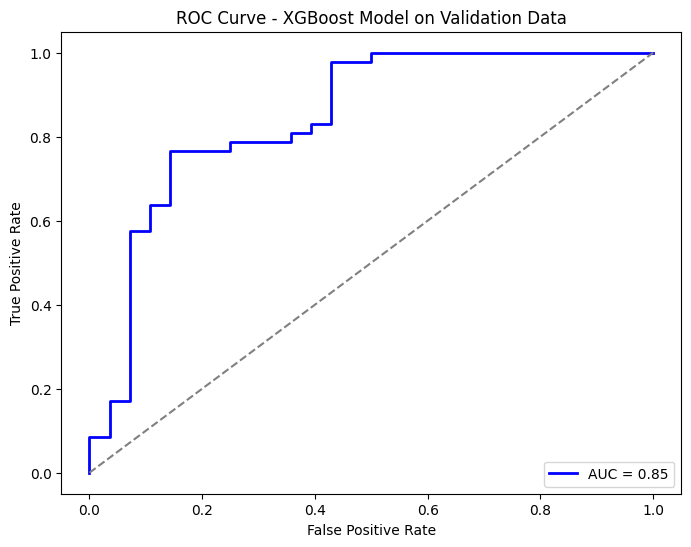

In [68]:
probs_val = best_model.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, probs_val)

auc_score = roc_auc_score(y_val, probs_val)
print(f"Area under the ROC curve: {auc_score}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Model on Validation Data')
plt.legend(loc='lower right')
plt.show()

#### 4. Compare the validation result you obtained using XGBoost with the results using the tree you implemented in part A. Which model did perform better and why?

The model implemented in part A performed better. Since this is a smaller dataset, XGBoost overfits the data due to which it has lower validation accuracy when compared to the self implemented decision tree in part A. For smaller datasets, decision trees would be expected to perform better than XGBoost. 

Although, in general XGBoost is expected to perform better than a simple decision tree. This is because decision trees lack regularization techniques which makes it prone to overfitting. Also, if the dataset is more complex, XGBoost will be effective in identifying the complex patterns in the data which a single decision tree will not be able to capture.

#### 5. Using the trained model, conduct inference on the test data and save the predicted result into the predictions csv file

In [69]:

test_data = pd.read_csv('data_test.csv')
test_data = test_data.drop(test_data.columns[0], axis=1)

test_data_encoded = test_data.copy()    
for col in categorical_cols:
    test_data_encoded[col] = label_encoder.fit_transform(test_data[col])

test_data_encoded = test_data_encoded[categorical_cols + numerical_cols]

predictions_file = pd.read_csv('Neha_Manghnani_preds.csv')

predictions_test = best_model.predict(test_data_encoded)
results = pd.DataFrame({'pred_xgboost': predictions_test})
predictions_file = pd.concat([predictions_file, results], axis=1)
predictions_file['pred_xgboost'] = predictions_file['pred_xgboost'].map({1: 'Y', 0: 'N'})


predictions_file.to_csv('Neha_Manghnani_preds.csv', index=False)